In [102]:
import pandas as pd
import numpy as np
import os
import math
import statistics

In [95]:
df = pd.read_csv('final_csvs/all_risk_df_ordered_NEW.csv', index_col=0)

In [96]:
df = df.fillna(0)

In [97]:
df = df.rename({'ranking_y':'ranking'}, axis=1)

In [98]:
df.head()

,matchId,teamId,distance1_2_x,distance1_3_x,distance1_4_x,distance2_3_x,distance2_4_x,distance3_4_x,distance_centroid1_x,distance_centroid2_x,distance_centroid3_x,distance_centroid4_x,cluster_A_x,cluster_B_x,cluster_C_x,cluster_D_x,n_players_y,distance1_2_y,distance1_3_y,distance1_4_y,distance2_3_y,distance2_4_y,distance3_4_y,distance_centroid1_y,distance_centroid2_y,distance_centroid3_y,distance_centroid4_y,cluster_A_y,cluster_B_y,cluster_C_y,cluster_D_y,agility_y,ranking,landing_risk1,landing_risk2,landing_risk3,landing_risk4,risk1,risk2,risk3,risk4,risk_std1,risk_std2,risk_std3,risk_std4
0,000fe633-8af8-4037-b318-a1ca39ded6df,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,0.000000,99.000000,99.000000,99.000000,1.000000,0.000000,0.000000,0.000000,0.000000,27.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.500000,0.000000,0.000000,0.000000,2.121320
1,000fe633-8af8-4037-b318-a1ca39ded6df,2,0.000000,0.000000,0.000000,0.156282,0.145812,0.501865,0.000000,0.529254,0.163375,0.147651,0.171105,0.146385,0.055556,0.000000,3,99.000000,99.000000,99.000000,1.053471,1.037536,0.357426,99.000000,0.482892,0.903331,0.816909,0.907407,0.083333,0.009259,0.000000,0.305556,24.0,2.0,19.0,49.0,0.0,4.100000,8.076923,2.650000,0.000000,6.463664,11.732511,2.661124,0.000000
2,000fe633-8af8-4037-b318-a1ca39ded6df,3,0.293267,0.278139,0.297879,0.253033,0.292031,0.428512,0.442286,0.437945,0.296466,0.322634,0.241380,0.149161,0.124758,0.056254,4,1.454560,1.453649,1.417359,1.210653,1.094311,0.563884,1.573802,1.473413,1.300607,1.229832,0.677305,0.196365,0.113032,0.013298,0.228723,1.0,0.0,0.0,1.0,0.0,0.731707,1.694301,0.450777,0.201258,1.830544,4.923881,0.934808,0.582225
3,000fe633-8af8-4037-b318-a1ca39ded6df,4,0.245417,0.256947,0.321464,0.274741,0.247003,0.272466,0.295594,0.275746,0.307125,0.348841,0.233654,0.159028,0.124771,0.044885,4,1.301105,1.282371,1.210068,1.206284,1.033670,0.679778,1.262137,1.196848,1.136787,1.075914,0.634615,0.217033,0.140110,0.008242,0.263736,17.0,0.0,0.0,0.0,0.0,0.553191,0.322581,0.414894,0.232558,1.528349,0.768416,0.781638,0.546097
4,000fe633-8af8-4037-b318-a1ca39ded6df,5,0.189662,0.169492,0.181803,0.180893,0.189781,0.237857,0.236857,0.209279,0.217836,0.284155,0.113364,0.113364,0.000000,0.000000,4,0.986669,0.993783,0.945808,0.849704,0.787576,0.571002,0.924418,0.874755,0.790567,0.674077,0.960843,0.039157,0.000000,0.000000,0.246988,8.0,4.0,0.0,0.0,0.0,0.630058,0.444444,0.568047,0.408602,1.843158,0.871572,1.252301,0.875221


First, we look at how many teams have null values in the distance columns, meaning that the teams are of less than 4 people. We look for 99s because we previously made all the distance nans to have value 99. 

In [99]:
for c in df.columns:
    if ('distance' in c) and ('y' in c):
        nns = len([i for i in df[c] if i == 99])
        total = len(df[c])
        print(f'{c} has {(nns/total)*100}% null values')

distance1_2_y has 30.69863000773687% null values
distance1_3_y has 31.357207555714904% null values
distance1_4_y has 31.435991546053256% null values
distance2_3_y has 15.511246768441115% null values
distance2_4_y has 15.94385107467024% null values
distance3_4_y has 12.380880493650105% null values
distance_centroid1_y has 29.587398335629235% null values
distance_centroid2_y has 11.764053742947182% null values
distance_centroid3_y has 8.573302134244146% null values
distance_centroid4_y has 4.222963410261733% null values


Then, we drop them. We decide to focus only on 4-player teams.

In [100]:
df = df.replace(99, np.nan)
df = df.dropna()
df = df.drop('n_players_y', axis=1)

For the risk variable, we derive a new interaction variable. This is risk * risk_std since we saw that they were highly correlated, so we try to capture the effect of the variance in risk with another variable.

In [104]:
col = df.loc[: , "risk_std1":"risk_std4"]
df['risk_std_mean'] = col.mean(axis=1)
col         = 'risk_std_mean'
conditions  = [ df[col] > statistics.median(df[col])+statistics.stdev(df[col]), (df[col]<statistics.median(df[col])+statistics.stdev(df[col])) & (df[col]>statistics.median(df[col])), df[col] <= statistics.median(df[col]) ]
# choices     = [ "Exploit", 'Ambidexter', 'Explore' ]
choices     = [ "1", '2', '3' ]
df["risk_category"] = np.select(conditions, choices, default=np.nan)
df = df.drop('risk_std_mean', axis=1)
df.risk_category = df.risk_category.astype(int)

In [105]:
df['risk_int1'] = df['risk1'] * df['risk_std1']
df['risk_int2'] = df['risk2'] * df['risk_std2']
df['risk_int3'] = df['risk3'] * df['risk_std3']
df['risk_int4'] = df['risk4'] * df['risk_std4']
df = df.drop(['risk_std1','risk_std2','risk_std3','risk_std4'], axis=1)

Now, we order risk variables from highest to lowest, so that the new variables represent from the riskiest player to the least risky player.

In [106]:
risk = df.loc[:, 'risk1':'risk4']
risk = np.sort(risk.values, axis=1)[:,::-1]
df.loc[:, 'risk1':'risk4'] = risk
risk_std = df.loc[:, 'risk_int1':'risk_int4']
risk_std = np.sort(risk_std.values, axis=1)[:,::-1]
df.loc[:, 'risk_int1':'risk_int4'] = risk_std
lrisk = df.loc[:, 'landing_risk1':'landing_risk4']
lrisk = np.sort(lrisk.values, axis=1)[:,::-1]
df.loc[:, 'landing_risk1':'landing_risk4'] = lrisk

Since the sum of the Cluster columns is always 1, we have a very high correlation. For that reason, we drop one of them. In this case, we drop Cluster A because we see that it is the one with the highest correlation with the others.

In [107]:
df.loc[:,'cluster_A_x':'cluster_D_x'].corr()

,cluster_A_x,cluster_B_x,cluster_C_x,cluster_D_x
cluster_A_x,1.000000,0.736391,0.832996,0.702728
cluster_B_x,0.736391,1.000000,0.441993,0.227359
cluster_C_x,0.832996,0.441993,1.000000,0.705948
cluster_D_x,0.702728,0.227359,0.705948,1.000000


In [108]:
df.loc[:,'cluster_A_y':'cluster_D_y'].corr()

,cluster_A_y,cluster_B_y,cluster_C_y,cluster_D_y
cluster_A_y,1.000000,-0.924929,-0.900766,-0.733466
cluster_B_y,-0.924929,1.000000,0.692111,0.483923
cluster_C_y,-0.900766,0.692111,1.000000,0.749447
cluster_D_y,-0.733466,0.483923,0.749447,1.000000


In [109]:
df = df.drop(['cluster_A_x','cluster_A_y'], axis=1)

Now, we merge rankpoints

In [110]:
rkpts = pd.read_csv('experience_data/rankpoints_csv.csv', index_col=0)
df = pd.merge(df, rkpts, how='left', on=['matchId', 'teamId'])

Next, we create the control variables for all the groups of variable.
We will use as control the mean of each group for the match. E.g. for pair distances, we will control for the mean pair player distance of the match.

In [111]:
group = df.groupby(['matchId']).mean().reset_index()
mean_distance = pd.concat([group.matchId, group[['distance1_2_y', 'distance1_3_y', 'distance1_4_y', 'distance2_3_y', 'distance2_4_y', 'distance3_4_y']].apply(np.mean, axis=1)], axis=1)
mean_distance.columns = ['matchId','distance_ctrl']
# mean_centroid = pd.concat([group.matchId, group[['distance_centroid1_y', 'distance_centroid2_y', 'distance_centroid3_y', 'distance_centroid4_y']].apply(np.mean, axis=1)], axis=1)
# mean_centroid.columns = ['matchId','centroid_ctrl']
mean_cluster = pd.concat([group.matchId, group[['cluster_B_y', 'cluster_C_y','cluster_D_y']].apply(np.mean, axis=1)], axis=1)
mean_cluster.columns = ['matchId','cluster_ctrl']
mean_distance_std = pd.concat([group.matchId, group[['distance1_2_x', 'distance1_3_x', 'distance1_4_x', 'distance2_3_x', 'distance2_4_x', 'distance3_4_x']].apply(np.mean, axis=1)], axis=1)
mean_distance_std.columns = ['matchId','distance_std_ctrl']
mean_cluster_std = pd.concat([group.matchId, group[['cluster_B_x', 'cluster_C_x','cluster_D_x']].apply(np.mean, axis=1)], axis=1)
mean_cluster_std.columns = ['matchId','cluster_std_ctrl']
mean_exp = pd.concat([group.matchId, group[['exp1', 'exp2', 'exp3', 'exp4']].apply(np.mean, axis=1)], axis=1)
mean_exp.columns = ['matchId','exp_ctrl']
mean_risk = pd.concat([group.matchId, group[['risk1', 'risk2', 'risk3', 'risk4']].apply(np.mean, axis=1)], axis=1)
mean_risk.columns = ['matchId','risk_ctrl']
# mean_lrisk = pd.concat([group.matchId, group[['landing_risk1', 'landing_risk2', 'landing_risk3', 'landing_risk4']].apply(np.mean, axis=1)], axis=1)
# mean_lrisk.columns = ['matchId','landing_risk_ctrl']
mean_agi = group[['matchId', 'agility_y']]
mean_agi.columns = ['matchId','agi_ctrl']
df = pd.merge(df, mean_distance, how = 'left', on="matchId")
# df = pd.merge(df, mean_centroid, how = 'left', on="matchId")
df = pd.merge(df, mean_cluster, how = 'left', on="matchId")
df = pd.merge(df, mean_distance_std, how = 'left', on="matchId")
df = pd.merge(df, mean_cluster_std, how = 'left', on="matchId")
df = pd.merge(df, mean_exp, how = 'left', on="matchId")
df = pd.merge(df, mean_risk, how = 'left', on="matchId")
# df = pd.merge(df, mean_lrisk, how = 'left', on="matchId")
df = pd.merge(df, mean_agi, how = 'left', on="matchId")

In [112]:
df['cluster_CD_x'] = (df['cluster_C_x'] + df['cluster_D_x']) / 2
df['cluster_CD_y'] = (df['cluster_C_y'] + df['cluster_D_y'])
cdx = df.pop('cluster_CD_x')
df.insert(df.columns.get_loc('cluster_D_x'), 'cluster_CD_x', cdx)
cdy = df.pop('cluster_CD_y')
df.insert(df.columns.get_loc('cluster_D_y'), 'cluster_CD_y', cdy)
df = df.drop(['cluster_C_x','cluster_C_y','cluster_D_x','cluster_D_y'], axis=1)

Now, since experience was already a control variable, we are going to engineer the variable. For that, we are going to normalize the experiences of the palyers by the mean experience of the match, and then we are going to get the aggregate experience for the team. We sum 1 to the denominator in case there is some mean exp that is equal to 0.

In [113]:
df['exp1'] = df['exp1'] / (df['exp_ctrl'] + 1)
df['exp2'] = df['exp2'] / (df['exp_ctrl'] + 1)
df['exp3'] = df['exp3'] / (df['exp_ctrl'] + 1)
df['exp4'] = df['exp4'] / (df['exp_ctrl'] + 1)
df['exp'] = df['exp1'] + df['exp2'] + df['exp3'] + df['exp4']
df = df.drop(['exp1','exp2','exp3','exp4', 'exp_ctrl'], axis=1)

Since we have many players for whom we don't know the experience, we are going to drop them.<br><BR>

In [114]:
df = df.dropna()
# for match in df.matchId.unique():
#     df.loc[df.matchId == match,'new_ranking'] = df.loc[df.matchId == match,'ranking'].rank()

To make things easiear, we make sure that ranking is the last column.

In [115]:
ranking = df.pop('ranking')
df.insert(df.shape[1], 'ranking', ranking)

Since we have many variables ordered, we drop the middle variables to stay only with max and min variables (they don't add much to the model).

In [116]:
df = df.drop(['distance1_3_x', 'distance1_4_x', 'distance2_3_x', 'distance2_4_x',
              'distance1_3_y', 'distance1_4_y', 'distance2_3_y', 'distance2_4_y', 
              'distance_centroid2_x', 'distance_centroid3_x', 'distance_centroid2_y', 'distance_centroid3_y',
              'risk2', 'risk3', 'risk_int2', 'risk_int3', 'landing_risk2','landing_risk3'], axis=1)

Now, let's remove the outliers. For that, we use the Z-score, and we will remove all rows with z-score bigger than 3 (3 standard deviations away from the mean)

In [119]:
from scipy import stats
import numpy as np
z = np.abs(stats.zscore(df.iloc[:,1:]))
print(z)

[[0.18856259 0.93110945 0.24749731 ... 0.83135551 0.74557228 1.15852716]
 [1.23460559 0.35442832 0.30976835 ... 0.83135551 0.74557228 1.2115935 ]
 [1.3805019  0.73448051 0.10699386 ... 0.70375823 0.74557228 0.81657339]
 ...
 [1.23460559 0.56356248 0.38191312 ... 0.9010903  0.74557228 1.15852716]
 [1.36536096 0.11510526 0.98630823 ... 0.9010903  0.74557228 0.1051402 ]
 [1.88838246 1.1257214  0.55852664 ... 0.9010903  0.74557228 1.55354726]]


In [120]:
df = df[(z < 3).all(axis=1)]

In [121]:
df.shape

(116673, 31)

Then, we separate the two df that we are going to study

In [122]:
pd.set_option('display.max_columns', 48)
pd.DataFrame(df.columns).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,matchId,teamId,distance1_2_x,distance3_4_x,distance_centroid1_x,distance_centroid4_x,cluster_B_x,cluster_CD_x,distance1_2_y,distance3_4_y,distance_centroid1_y,distance_centroid4_y,cluster_B_y,cluster_CD_y,agility_y,landing_risk1,landing_risk4,risk1,risk4,risk_std_mean,risk_category,risk_int1,risk_int4,distance_ctrl,cluster_ctrl,distance_std_ctrl,cluster_std_ctrl,risk_ctrl,agi_ctrl,exp,ranking


In [140]:
# distances and centroids
df1 = pd.concat([df.iloc[:,0:6], df.iloc[:,8:12], df.iloc[:,14:24], df.iloc[:,25:]], axis=1)

# distances and clusters
df2 = pd.concat([df.iloc[:,0:4], df.iloc[:,6:10], df.iloc[:,12:]], axis=1)


Here, I just check the correlations. There is probably something that we can do about high correlations, though.

In [128]:
df2.iloc[:,2:].corr().style.apply(lambda x: ["background: red" if abs(v) > 0.75 else "" for v in x], axis = 1)

,distance1_2_x,distance3_4_x,cluster_B_x,cluster_CD_x,distance1_2_y,distance3_4_y,cluster_B_y,cluster_CD_y,agility_y,landing_risk1,landing_risk4,risk1,risk4,risk_category,risk_int1,risk_int4,distance_ctrl,cluster_ctrl,distance_std_ctrl,cluster_std_ctrl,risk_ctrl,agi_ctrl,exp,ranking
distance1_2_x,1,0.140369,0.11813,0.104817,-0.125989,0.00409281,0.0406876,0.0650064,-0.247188,-0.0674868,-0.0682652,-0.0701422,-0.077566,0.0757608,-0.049999,-0.0397859,0.0343907,0.0902095,0.250052,0.106699,-0.0976225,-0.112231,0.0087502,-0.202525
distance3_4_x,0.140369,1,0.0362206,0.157553,0.123578,-0.148127,0.0451428,0.146016,0.0165431,-0.0518062,-0.0339085,-0.0801601,-0.0492208,0.0574492,-0.0546994,-0.0350076,-0.0730866,-0.120113,0.213075,-0.110914,0.0495635,0.0849993,0.0478728,-0.154634
cluster_B_x,0.11813,0.0362206,1,0.362634,0.305359,0.240227,0.648841,0.232435,0.0609316,-0.199067,-0.279304,-0.226535,-0.354131,0.243574,-0.163442,-0.282082,0.13568,0.289772,-0.0181603,0.322026,-0.213445,-0.0500515,-0.068687,-0.0955824
cluster_CD_x,0.104817,0.157553,0.362634,1,0.447216,0.50591,0.637313,0.911476,-0.0113265,-0.337673,-0.368884,-0.340093,-0.447399,0.405511,-0.247848,-0.337503,0.141374,0.475755,0.00511902,0.499288,-0.3714,-0.107645,-0.0907913,-0.00158947
distance1_2_y,-0.125989,0.123578,0.305359,0.447216,1,0.444074,0.613152,0.467431,-0.0523408,-0.0941974,-0.17417,-0.111795,-0.248421,0.132351,-0.0685336,-0.203917,0.129049,0.00167965,0.0074561,-0.00672969,0.0397432,-0.0466456,-0.0191863,-0.234285
distance3_4_y,0.00409281,-0.148127,0.240227,0.50591,0.444074,1,0.357104,0.487255,0.0423635,-0.133036,-0.166616,-0.137705,-0.245735,0.17288,-0.0909156,-0.21025,0.0779969,0.00300259,-0.0439047,0.0159108,-0.0137791,0.0203493,0.00121733,-0.155505
cluster_B_y,0.0406876,0.0451428,0.648841,0.637313,0.613152,0.357104,1,0.621418,0.0677816,-0.238719,-0.321019,-0.23179,-0.392008,0.293774,-0.167044,-0.309463,0.154421,0.38094,-0.0288151,0.358925,-0.230815,-0.0884149,-0.0674485,0.0545162
cluster_CD_y,0.0650064,0.146016,0.232435,0.911476,0.467431,0.487255,0.621418,1,-0.0174207,-0.287951,-0.298952,-0.277622,-0.367556,0.345209,-0.202624,-0.275509,0.120449,0.400794,-0.00163814,0.394281,-0.281203,-0.0993963,-0.0566723,0.0412207
agility_y,-0.247188,0.0165431,0.0609316,-0.0113265,-0.0523408,0.0423635,0.0677816,-0.0174207,1,-0.0267553,0.0171198,-0.0829154,-0.0171841,0.0392409,-0.0678278,-0.0418736,-0.120119,-0.10111,-0.00951232,-0.0844209,-0.00811722,0.349495,0.0105626,0.375962
landing_risk1,-0.0674868,-0.0518062,-0.199067,-0.337673,-0.0941974,-0.133036,-0.238719,-0.287951,-0.0267553,1,0.450991,0.658931,0.533548,-0.669991,0.592753,0.462258,-0.0542862,-0.302197,-0.0580158,-0.343862,0.423238,-0.00182244,0.0880228,-0.0187616


# EDA

In [25]:
pd.set_option('display.max_columns', 45)

In [26]:
df.columns

Index(['matchId', 'teamId', 'distance1_2_x', 'distance3_4_x',
       'distance_centroid1_x', 'distance_centroid4_x', 'cluster_B_x',
       'cluster_C_x', 'cluster_D_x', 'distance1_2_y', 'distance3_4_y',
       'distance_centroid1_y', 'distance_centroid4_y', 'cluster_B_y',
       'cluster_C_y', 'cluster_D_y', 'agility_y', 'landing_risk1',
       'landing_risk4', 'risk1', 'risk4', 'risk_int1', 'risk_int4',
       'distance_ctrl', 'cluster_ctrl', 'risk_ctrl', 'agi_ctrl', 'exp',
       'ranking'],
      dtype='object')

The _x_ variables represent standard deviations, while the _y_ variables represent means

In [27]:
df.nunique(axis=0)
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,teamId,distance1_2_x,distance3_4_x,distance_centroid1_x,distance_centroid4_x,cluster_B_x,cluster_C_x,cluster_D_x,distance1_2_y,distance3_4_y,distance_centroid1_y,distance_centroid4_y,cluster_B_y,cluster_C_y,cluster_D_y,agility_y,landing_risk1,landing_risk4,risk1,risk4,risk_int1,risk_int4,distance_ctrl,cluster_ctrl,risk_ctrl,agi_ctrl,exp,ranking
count,116460.000000,116460.000000,116460.000000,116460.000000,116460.000000,116460.000000,116460.000000,116460.000000,116460.000000,116460.000000,116460.000000,116460.000000,116460.000000,116460.000000,116460.000000,116460.000000,116460.000000,116460.000000,116460.000000,116460.000000,116460.000000,116460.000000,116460.000000,116460.000000,116460.000000,116460.000000,116460.000000,116460.000000
mean,12.630276,0.249450,0.266791,0.419135,0.300986,0.133796,0.066880,0.024283,1.162329,0.620928,1.057652,0.884371,0.114916,0.033513,0.006918,0.236498,27.689005,3.044925,10.227844,3.408269,266.329296,39.421505,0.976110,0.054210,7.605586,0.235966,1.508069,12.031822
std,7.665311,0.092731,0.068656,0.242713,0.156906,0.044719,0.044007,0.031047,0.196986,0.131901,0.287552,0.231492,0.073501,0.035980,0.012169,0.109656,29.097132,5.348008,11.252736,4.207794,503.473013,81.954700,0.024231,0.018183,5.015966,0.042082,2.039325,7.575852
min,1.000000,0.027609,0.018898,0.054803,0.001754,0.000000,0.000000,0.000000,0.516618,0.141848,-0.493141,-0.865191,0.000000,0.000000,0.000000,0.011299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.897604,0.005473,0.000000,0.105676,0.000000,1.000000
25%,6.000000,0.182505,0.222572,0.294490,0.223064,0.112497,0.033113,0.000000,1.030273,0.531442,0.897695,0.725332,0.055060,0.004348,0.000000,0.153061,6.000000,0.000000,1.921348,0.536913,6.730539,0.614195,0.959963,0.039911,3.596354,0.207984,0.000000,6.000000
50%,12.000000,0.237782,0.264520,0.379670,0.282205,0.136736,0.070582,0.000000,1.152275,0.618307,1.081680,0.858338,0.108696,0.020833,0.000000,0.224806,18.000000,1.000000,5.938686,1.526316,52.529035,4.160699,0.976501,0.054181,6.209828,0.236822,0.000000,11.000000
75%,18.000000,0.304030,0.307738,0.499352,0.348709,0.161035,0.104855,0.045893,1.277888,0.706242,1.248189,1.016885,0.165644,0.053030,0.008621,0.304598,39.062500,3.125000,14.937500,4.850746,282.504013,37.020362,0.992451,0.067864,11.187218,0.264859,3.599077,18.000000
max,35.000000,0.629297,0.515999,8.414860,5.626839,0.255377,0.167577,0.113067,1.833634,1.094686,2.651593,2.416291,0.351592,0.163146,0.062500,0.587302,150.000000,30.000000,60.790698,22.390805,3715.016273,734.343312,1.052881,0.109152,23.675138,0.363349,7.723608,33.000000


distance1_2_x


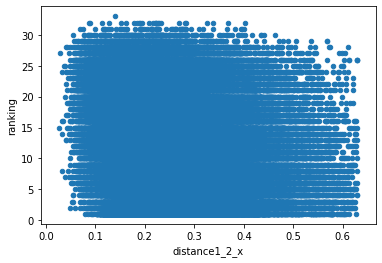

distance3_4_x


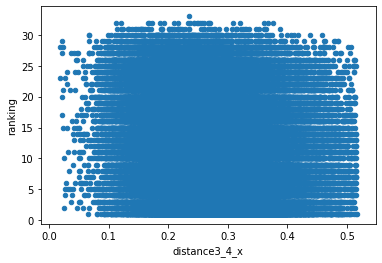

distance_centroid1_x


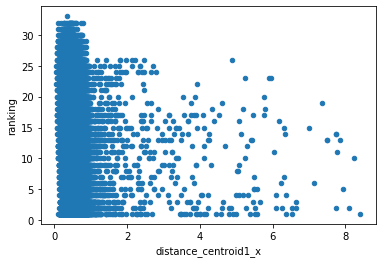

distance_centroid4_x


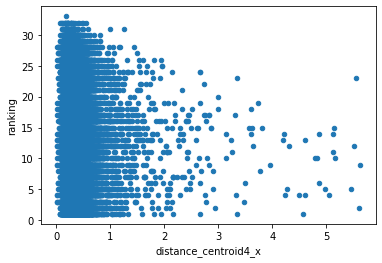

cluster_B_x


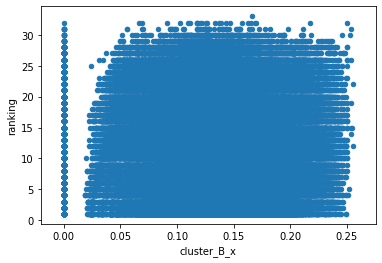

cluster_C_x


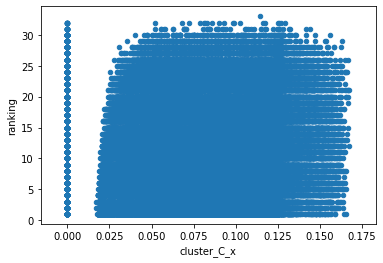

cluster_D_x


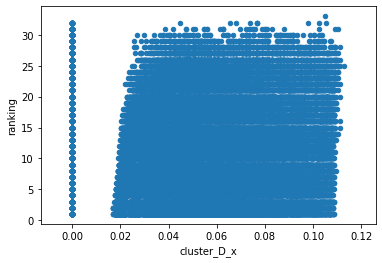

distance1_2_y


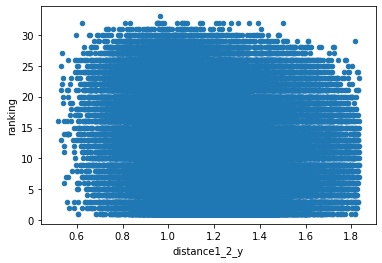

distance3_4_y


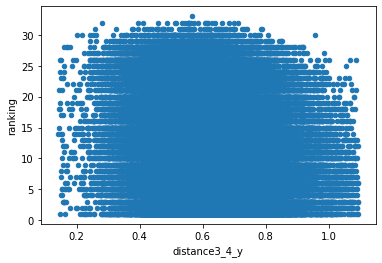

distance_centroid1_y


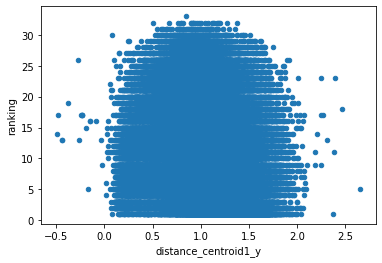

distance_centroid4_y


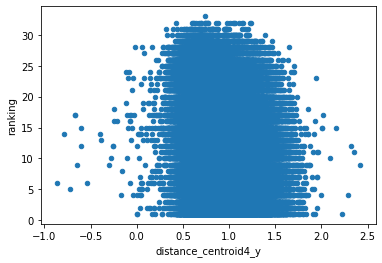

cluster_B_y


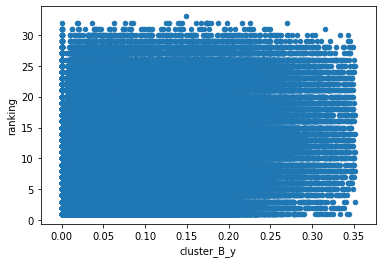

cluster_C_y


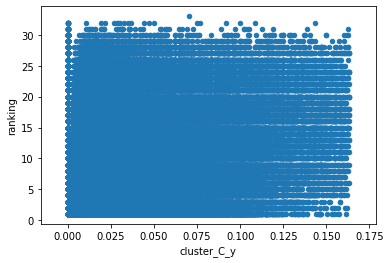

cluster_D_y


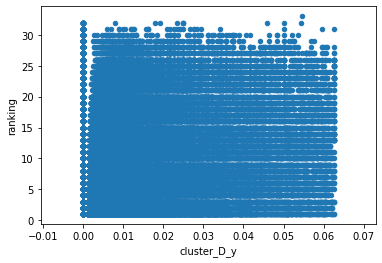

agility_y


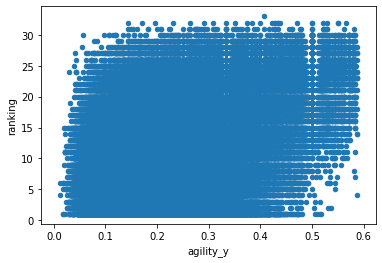

landing_risk1


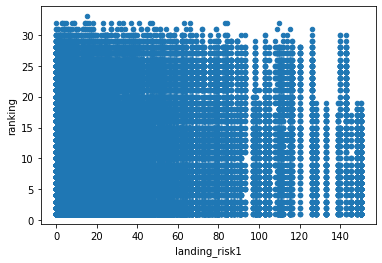

landing_risk4


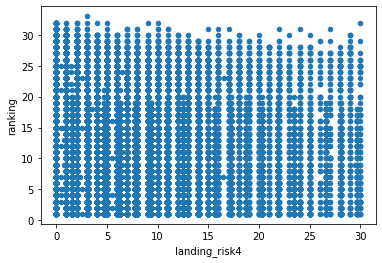

risk1


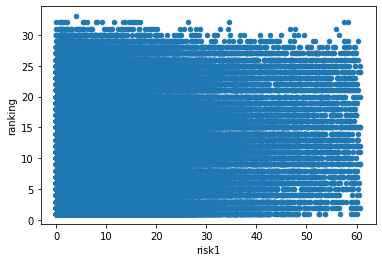

risk4


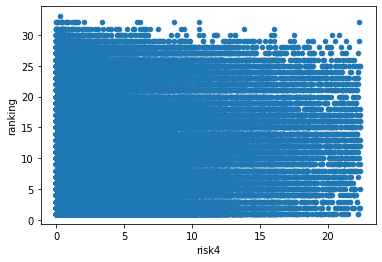

risk_int1


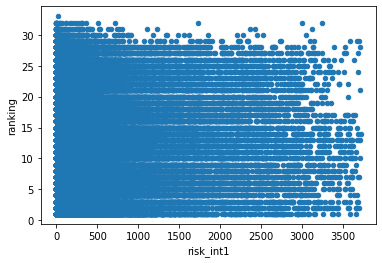

risk_int4


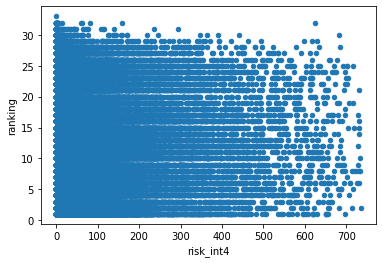

distance_ctrl


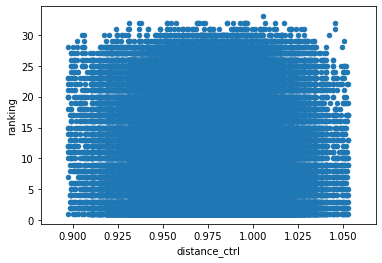

cluster_ctrl


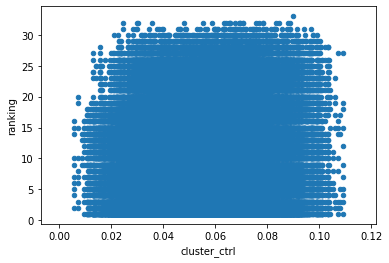

risk_ctrl


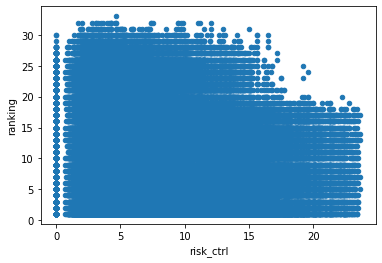

agi_ctrl


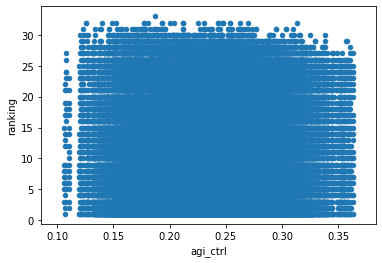

exp


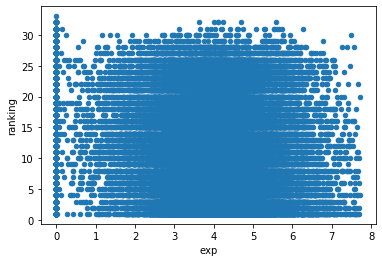

ranking


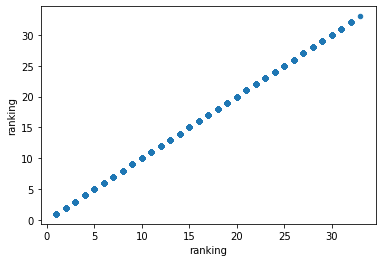

In [180]:
for i in df.iloc[:,2:].columns:
    print(f'{i}')
    df.plot.scatter(i,'ranking')
    plt.show()

distance1_2_x


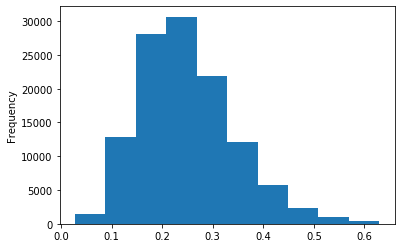

distance3_4_x


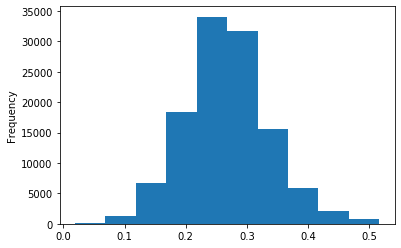

distance_centroid1_x


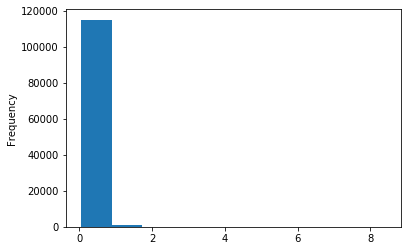

distance_centroid4_x


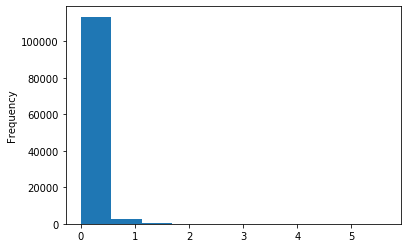

cluster_B_x


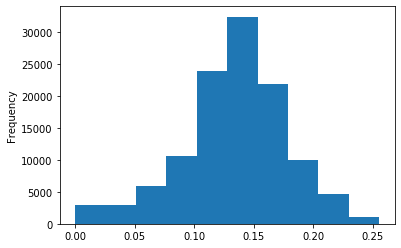

cluster_C_x


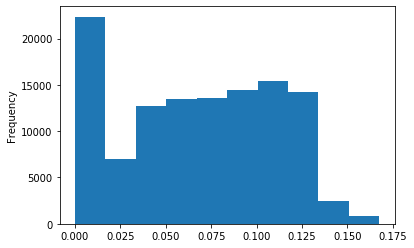

cluster_D_x


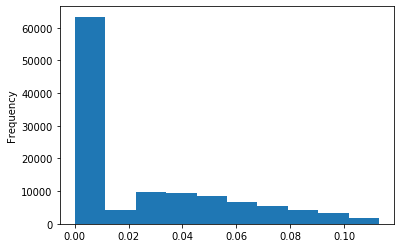

distance1_2_y


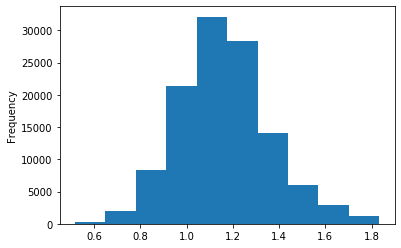

distance3_4_y


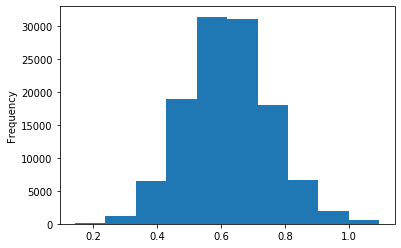

distance_centroid1_y


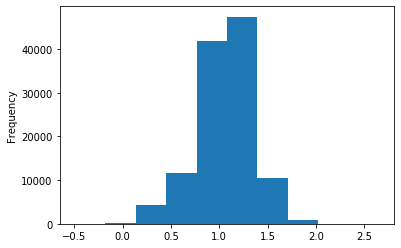

distance_centroid4_y


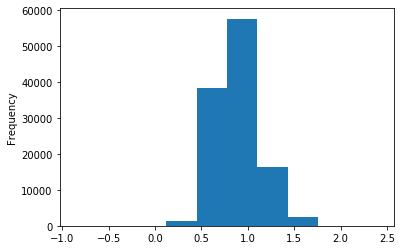

cluster_B_y


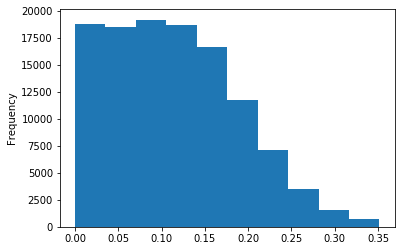

cluster_C_y


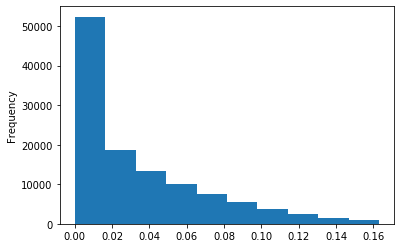

cluster_D_y


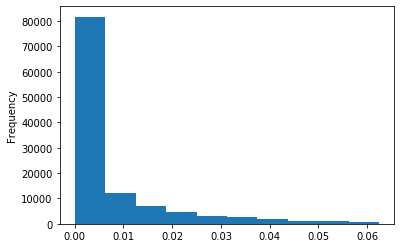

agility_y


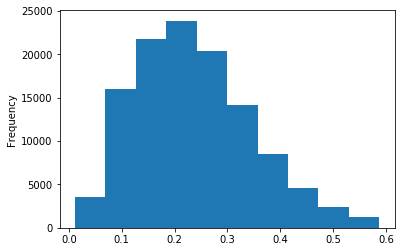

landing_risk1


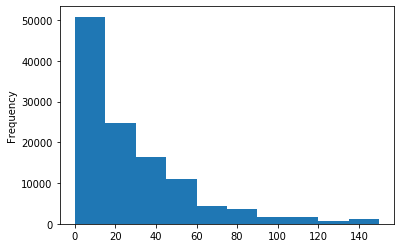

landing_risk4


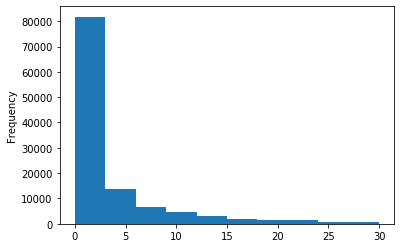

risk1


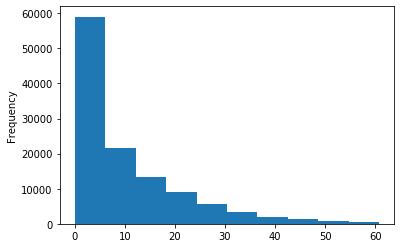

risk4


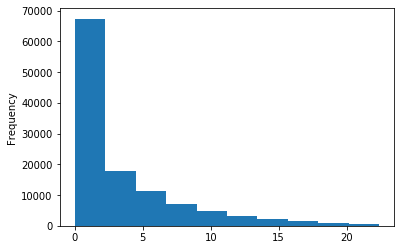

risk_int1


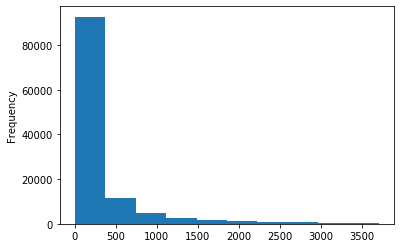

risk_int4


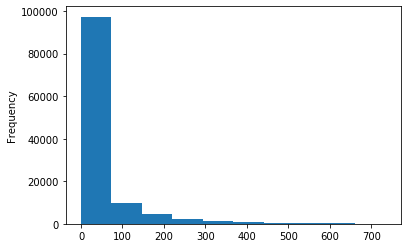

distance_ctrl


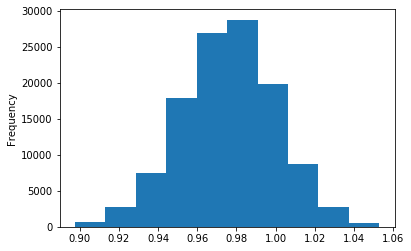

cluster_ctrl


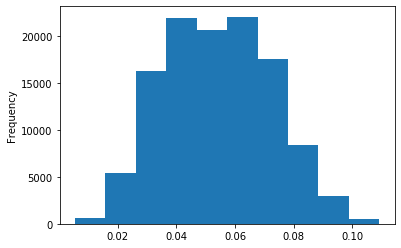

risk_ctrl


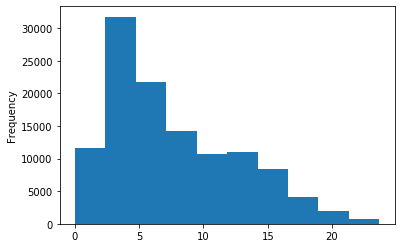

agi_ctrl


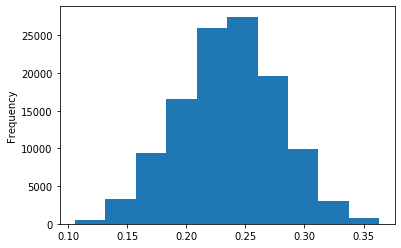

exp


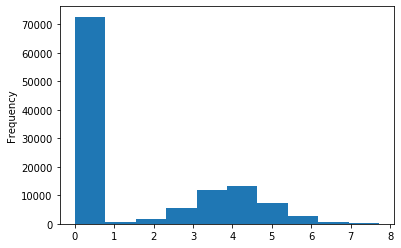

ranking


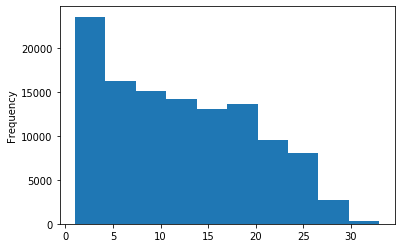

In [179]:
for i in df.iloc[:,2:].columns:
    print(f'{i}')
    df[i].plot.hist()
    plt.show()

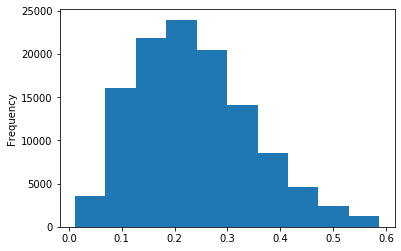

In [143]:
df['agility_y'].plot.hist()

# Models

In [73]:
import numpy as np
import pandas as pd
import os
import math
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, SGDClassifier
from sklearn.svm import SVR
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier, XGBRegressor

## All variables

From now on, I use the df with distances and cluster, not centroids

In [148]:
X = df2.iloc[:,2:-1]
y = df2.iloc[:,[-1]]

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=6, shuffle=True)

### Regression

In [150]:
# Linear Regression
X_t=sm.add_constant(X_train)
model = sm.OLS(y_train,X_t.astype(float), hasconst=True)
model = model.fit(cov_type = 'HC1')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ranking   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     3701.
Date:                Sun, 28 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:22:04   Log-Likelihood:            -2.9475e+05
No. Observations:               93338   AIC:                         5.895e+05
Df Residuals:                   93314   BIC:                         5.898e+05
Df Model:                          23                                         
Covariance Type:                  HC1                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                25.4465      0.943     26.976      0.000      23.598      27.295
distance1_2_x       -13.6480      0.242    -56.476      0.000     -14.122     -13.174
distance3_4_x       -12.7852      0.339    -37.659      0.000     -13.451     -12.120
cluster_B_x         -36.1378      0.634    -56.971      0.000     -37.381     -34.895
cluster_CD_x        -28.8095      1.578    -18.256      0.000     -31.902     -25.717
distance1_2_y       -13.7152      0.165    -83.125      0.000     -14.039     -13.392
distance3_4_y        -8.3966      0.202    -41.616      0.000      -8.792      -8.001
cluster_B_y          39.4863      0.532     74.196      0.000      38.443      40.529
cluster_CD_y         37.5896      1.052     35.744      0.000      35.528      39.651
agility_y            24.9355      0.195    128.121      0.000      24.554      25.317
landing_risk1        -0.0076      0.001     -8.541      0.000      -0.009      -0.006
landing_risk4        -0.0412      0.004    -10.053      0.000      -0.049      -0.033
risk1                 0.5292      0.006     85.289      0.000       0.517       0.541
risk4                -0.0222      0.014     -1.571      0.116      -0.050       0.006
risk_category         1.5636      0.048     32.530      0.000       1.469       1.658
risk_int1            -0.0061      0.000    -58.499      0.000      -0.006      -0.006
risk_int4            -0.0062      0.001    -10.467      0.000      -0.007      -0.005
distance_ctrl         3.7910      0.889      4.263      0.000       2.048       5.534
cluster_ctrl       -136.8160      3.435    -39.825      0.000    -143.549    -130.083
distance_std_ctrl    20.4582      0.922     22.182      0.000      18.651      22.266
cluster_std_ctrl    105.0473      3.947     26.614      0.000      97.311     112.783
risk_ctrl            -0.3871      0.006    -60.746      0.000      -0.400      -0.375
agi_ctrl            -16.2062      0.535    -30.268      0.000     -17.256     -15.157
exp                  -0.1056      0.009    -11.312      0.000      -0.124      -0.087
==============================================================================
Omnibus:                      964.064   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              954.525
Skew:                           0.229   Prob(JB):                    5.34e-208
Kurtosis:                       2.813   Cond. No.                     1.51e+05
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 1.51e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [151]:
X_t1 = X_t.drop(['landing_risk1','landing_risk4', 'risk1','risk4','risk_int1','risk_int4', 'risk_ctrl'], axis=1)
# Linear Regression
model1 = sm.OLS(y_train,X_t1.astype(float), hasconst=True).fit()

model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ranking   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     3407.
Date:                Sun, 28 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:24:24   Log-Likelihood:            -3.0003e+05
No. Observations:               93338   AIC:                         6.001e+05
Df Residuals:                   93321   BIC:                         6.003e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                24.9968      0.968     25.830      0.000      23.100      26.894
distance1_2_x       -14.3970      0.243    -59.202      0.000     -14.874     -13.920
distance3_4_x       -14.8826      0.337    -44.140      0.000     -15.543     -14.222
cluster_B_x         -41.8511      0.668    -62.657      0.000     -43.160     -40.542
cluster_CD_x        -31.0146      1.654    -18.757      0.000     -34.256     -27.774
distance1_2_y       -14.8465      0.151    -98.509      0.000     -15.142     -14.551
distance3_4_y        -8.3429      0.205    -40.622      0.000      -8.745      -7.940
cluster_B_y          44.6370      0.536     83.273      0.000      43.586      45.688
cluster_CD_y         36.6149      1.112     32.934      0.000      34.436      38.794
agility_y            23.1421      0.205    112.881      0.000      22.740      23.544
risk_category        -0.4608      0.030    -15.255      0.000      -0.520      -0.402
distance_ctrl         3.7787      0.945      3.999      0.000       1.927       5.631
cluster_ctrl       -158.7390      3.542    -44.810      0.000    -165.682    -151.796
distance_std_ctrl    26.5406      0.955     27.801      0.000      24.670      28.412
cluster_std_ctrl    192.7175      3.793     50.813      0.000     185.284     200.151
agi_ctrl            -11.5457      0.543    -21.257      0.000     -12.610     -10.481
exp                  -0.1283      0.010    -12.882      0.000      -0.148      -0.109
==============================================================================
Omnibus:                     1602.550   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1442.586
Skew:                           0.256   Prob(JB):                         0.00
Kurtosis:                       2.670   Cond. No.                         908.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [152]:
X_t2 = X_t1.drop(['cluster_B_x','cluster_CD_x','cluster_B_y','cluster_CD_y'], axis=1)
# Linear Regression
model2 = sm.OLS(y_train,X_t2.astype(float), hasconst=True).fit()

model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ranking   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     2953.
Date:                Sun, 28 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:24:25   Log-Likelihood:            -3.0648e+05
No. Observations:               93338   AIC:                         6.130e+05
Df Residuals:                   93325   BIC:                         6.131e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                24.5218      1.037     23.651      0.000      22.490      26.554
distance1_2_x       -12.9134      0.255    -50.652      0.000     -13.413     -12.414
distance3_4_x       -13.4286      0.335    -40.124      0.000     -14.085     -12.773
distance1_2_y        -6.3182      0.126    -50.058      0.000      -6.566      -6.071
distance3_4_y        -6.0092      0.186    -32.275      0.000      -6.374      -5.644
agility_y            25.8327      0.214    120.800      0.000      25.414      26.252
risk_category        -0.3060      0.032     -9.521      0.000      -0.369      -0.243
distance_ctrl        -9.4638      0.997     -9.493      0.000     -11.418      -7.510
cluster_ctrl        -48.2528      3.652    -13.213      0.000     -55.410     -41.095
distance_std_ctrl    22.9599      1.016     22.598      0.000      20.969      24.951
cluster_std_ctrl    130.3800      3.847     33.894      0.000     122.841     137.920
agi_ctrl            -13.6101      0.580    -23.483      0.000     -14.746     -12.474
exp                  -0.1267      0.011    -11.876      0.000      -0.148      -0.106
==============================================================================
Omnibus:                     3416.720   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1569.433
Skew:                           0.069   Prob(JB):                         0.00
Kurtosis:                       2.380   Cond. No.                         871.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [153]:
y_pred = model.predict(X_t)

In [154]:
diff = y_train.copy()
diff['pred'] = y_pred

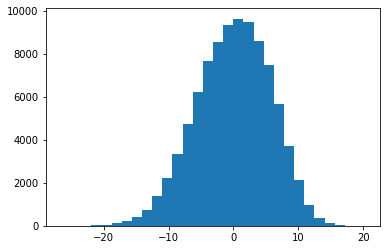

In [155]:
plt.hist([diff['pred']-diff['ranking']], bins=30)
plt.show()

Check the distribution of the errors 

In [156]:
metrics.r2_score(y_train, y_pred)

0.4362675057199281

In [157]:
mean_squared_error(y_train, y_pred)

32.388503358231546

In [158]:
X_ts = sm.add_constant(X_test)
y_pred = model.predict(X_ts)

C:\Users\admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [159]:
metrics.r2_score(y_test, y_pred)

0.4490727260450429

In [160]:
mean_squared_error(y_test, y_pred)

31.547659082883328

In [161]:
# Linear regression (scikit learn)
kfold=KFold(n_splits=10, random_state=7)

model=LinearRegression()
scoring = "neg_mean_squared_error"

results=cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
print(f'Linear Regression - MSE {results.mean():.3f} std {results.std():.3f}')

# Create the DataFrames for plotting
resall=pd.DataFrame()
res_w1=pd.DataFrame()

res_w1["Res"]=results
res_w1["Type"]="Lin"

resall=pd.concat([resall,res_w1], ignore_index=True)

# Now lets use it in the same way than the statsmodel

model_x=LinearRegression()
model_x.fit(X_train,y_train)
print(f'Intercept {model_x.intercept_}')
print("Coefficients ",model_x.coef_)

y_pred_x=model_x.predict(X_train)

print(f'MAE - Mean Absolute Error {mean_absolute_error(y_train, y_pred_x):.3f}')
print(f'MSE - Mean Square Error  {mean_squared_error(y_train, y_pred_x):.3f}')
print(f'R2    {metrics.r2_score(y_train, y_pred_x):.3f}')

Linear Regression - MSE -32.405 std 0.415
Intercept [25.44654988]
Coefficients  [[-1.36479797e+01 -1.27851741e+01 -3.61377846e+01 -2.88095125e+01
  -1.37152367e+01 -8.39657453e+00  3.94862612e+01  3.75895689e+01
   2.49354684e+01 -7.62571642e-03 -4.11552226e-02  5.29233869e-01
  -2.22398815e-02  1.56356369e+00 -6.14824298e-03 -6.20668284e-03
   3.79098826e+00 -1.36815954e+02  2.04581946e+01  1.05047283e+02
  -3.87103409e-01 -1.62061701e+01 -1.05570173e-01]]
MAE - Mean Absolute Error 4.610
MSE - Mean Square Error  32.389
R2    0.436


In [162]:
y_pred = model_x.predict(X_test)

In [163]:
# Ridge Regression
kfold=KFold(n_splits=10, random_state=7)

model=Ridge()
scoring = "neg_mean_squared_error"

results=cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

print(f'Ridge Regression - MSE {results.mean():.3f} std {results.std():.3f}')

res_w1["Res"]=results
res_w1["Type"]="Ridge"

resall=pd.concat([resall,res_w1], ignore_index=True)

Ridge Regression - MSE -32.494 std 0.411


In [164]:
model=Ridge()
model.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [165]:
y_pred = model.predict(X_train)

In [166]:
metrics.r2_score(y_train, y_pred)

0.4348826026250504

In [167]:
mean_squared_error(y_train, y_pred)

32.46807113017018

In [168]:
y_pred = model.predict(X_test)

In [169]:
metrics.r2_score(y_test, y_pred)

0.44751097362713255

In [170]:
mean_squared_error(y_test, y_pred)

31.63708945814577

In [171]:
# KNN Regression
kfold=KFold(n_splits=10, random_state=7)

model=KNeighborsRegressor()
scoring = "neg_mean_squared_error"

results=cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)

print(f'KNN Regression - MSE {results.mean():.3f} std {results.std():.3f}')

res_w1["Res"]=results
res_w1["Type"]="KNN"

resall=pd.concat([resall,res_w1], ignore_index=True)

KeyboardInterrupt: 

In [ ]:
model=KNeighborsRegressor()
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_train)

In [ ]:
metrics.r2_score(y_train, y_pred)

In [ ]:
mean_squared_error(y_train, y_pred)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
metrics.r2_score(y_test, y_pred)

In [ ]:
mean_squared_error(y_test, y_pred)

### Classification

In [181]:
dfc = df2.copy()
dfc['ranking'] = dfc['ranking'].apply(lambda x: 1 if x <=5 else 0)

In [182]:
X = dfc.iloc[:,2:-1]
y = dfc.iloc[:,-1]

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=6, shuffle = True)

In [175]:
scaler = MinMaxScaler()
#scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

LOGISTIC REGRESSION

In [184]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [185]:
y_pred = model.predict(X_train)
print('TRAIN METRICS')
print(f'Accuracy: {metrics.accuracy_score(y_train, y_pred)}')
print(f'F1 Score: {metrics.f1_score(y_train, y_pred)}')
metrics.confusion_matrix(y_train,y_pred)

TRAIN METRICS
Accuracy: 0.7169753821246607
F1 Score: 0.577296712987327


array([[54992, 23928],
       [ 5791, 20294]], dtype=int64)

In [186]:
print(metrics.classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.70      0.79     78920
           1       0.46      0.78      0.58     26085

    accuracy                           0.72    105005
   macro avg       0.68      0.74      0.68    105005
weighted avg       0.79      0.72      0.74    105005



In [187]:
y_pred = model.predict(X_test)
print('TEST METRICS')
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'F1 Score: {metrics.f1_score(y_test, y_pred)}')
metrics.confusion_matrix(y_test,y_pred)

TEST METRICS
Accuracy: 0.7193177922523141
F1 Score: 0.5803971812940423


array([[6128, 2644],
       [ 631, 2265]], dtype=int64)

In [188]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.70      0.79      8772
           1       0.46      0.78      0.58      2896

    accuracy                           0.72     11668
   macro avg       0.68      0.74      0.68     11668
weighted avg       0.80      0.72      0.74     11668



STOCHASTIC GRADIENT DESCENT

In [189]:
model = SGDClassifier(class_weight='balanced')
model.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [190]:
y_pred = model.predict(X_train)
print('TRAIN METRICS')
print(f'Accuracy: {metrics.accuracy_score(y_train, y_pred)}')
print(f'F1 Score: {metrics.f1_score(y_train, y_pred)}')
metrics.confusion_matrix(y_train,y_pred)

TRAIN METRICS
Accuracy: 0.7050330936622066
F1 Score: 0.46375456638792223


array([[60639, 18281],
       [12692, 13393]], dtype=int64)

In [191]:
y_pred = model.predict(X_test)
print('TEST METRICS')
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'F1 Score: {metrics.f1_score(y_test, y_pred)}')
metrics.confusion_matrix(y_test,y_pred)

TEST METRICS
Accuracy: 0.7056050737058622
F1 Score: 0.4668632624553779


array([[6729, 2043],
       [1392, 1504]], dtype=int64)

XGBCLASSIFIER

In [192]:
len([i for i in y_train if i == 0]) / len([i for i in y_train if i == 1])

3.025493578685068

In [194]:
model = XGBClassifier(scale_pos_weight=2, booster='gbtree', gamma=65, min_child_weight=50)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=65, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=50, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=2, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [195]:
y_pred = model.predict(X_train)
print('TRAIN METRICS')
print(f'Accuracy: {metrics.accuracy_score(y_train, y_pred)}')
print(f'F1 Score: {metrics.f1_score(y_train, y_pred)}')
metrics.confusion_matrix(y_train,y_pred)

TRAIN METRICS
Accuracy: 0.7903147469168135
F1 Score: 0.6367385996172374


array([[63690, 15230],
       [ 6788, 19297]], dtype=int64)

In [196]:
print(metrics.classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.81      0.85     78920
           1       0.56      0.74      0.64     26085

    accuracy                           0.79    105005
   macro avg       0.73      0.77      0.74    105005
weighted avg       0.82      0.79      0.80    105005



In [197]:
metrics.average_precision_score(y_train,y_pred)

0.47810112064415267

In [198]:
metrics.roc_auc_score(y_pred,y_train)

0.7312910966088364

In [199]:
y_pred = model.predict(X_test)
print('TEST METRICS')
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(f'F1 Score: {metrics.f1_score(y_test, y_pred)}')
metrics.confusion_matrix(y_test,y_pred)

TEST METRICS
Accuracy: 0.7796537538567021
F1 Score: 0.6163259215042531


array([[7032, 1740],
       [ 831, 2065]], dtype=int64)

In [200]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.80      0.85      8772
           1       0.54      0.71      0.62      2896

    accuracy                           0.78     11668
   macro avg       0.72      0.76      0.73     11668
weighted avg       0.81      0.78      0.79     11668



In [201]:
metrics.average_precision_score(y_test,y_pred)

0.4581989822733413

In [202]:
metrics.roc_auc_score(y_pred,y_test)

0.7185110557054339

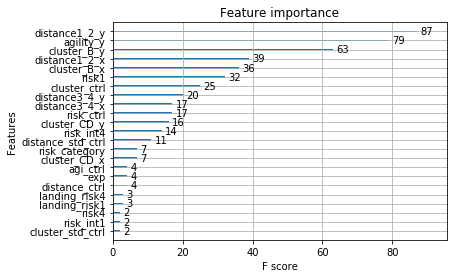

In [203]:
from xgboost import plot_importance
plot_importance(model.get_booster())